In [10]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [11]:
# Import the screenings library
import sys
sys.path.append( '../src' )
import screenings as sc

In [12]:
import numpy as np
import pandas as pd

In [13]:
files5 = !ls ../fixed/batch5
files6 = !ls ../fixed/batch6
cond5 = {'-'.join( x.split('-')[:2] ) for x in files5}
cond6 = {'-'.join( x.split('-')[:2] ) for x in files6}

In [15]:
reps = ('8_A',
        '8_B',
        '8_C',)
plates = {}
for b, cond, files in zip(('batch5',
                           'batch6'),
                           (cond5,
                            cond6),
                           (files5,
                            files6)):
    for c in cond:
        data = {}
        for rep in reps:
            try:
                fa = [x for x in files if x.startswith(c) and rep in x][0]
            except IndexError:
                continue
            ma = sc.parse_iris('../fixed/%s/'%b + fa,
                               '../plates.tsv',
                               rep.split('_')[0])
            pmm = sc.plate_middle_mean(ma)
            ma = sc.normalize_outer(ma, pmm=True)
            ca = (ma['colony size'] -
                  np.median(ma.loc['NT12001']['colony size'])) / float(sc.plate_middle_mean(ma))
            strains = set(ca.index)
            remove = set()
            for s in strains:
                if sc.variance(ca[s]) > 0.2:
                    remove.add( s )
            if 'NT12001' in remove:
                continue
            ca.drop(remove)
            da = {x:ca[x].dropna().mean() for x in set(ca.index)}
            ia = pd.DataFrame(da.values())
            ia.index = da.keys()
            data[rep] = ia
        if len(data) < 3:
            continue
        plate = pd.concat(data.values(), axis=1)
        plate.columns = data.keys()
        strains = set(plate.index)
        remove = set()
        for s in strains:
            if sc.variance(plate.loc[s]) > 0.1:
                remove.add( s )
        if 'NT12001' in remove:
            continue
        plate.drop(remove)
        plate = plate.dropna().T.mean()
        if plate.shape[0] == 0:
            continue
        plates[c] = plate

In [16]:
matrix = pd.concat(plates.values(), axis=1)
matrix.columns = [x.upper() for x in plates.keys()]
matrix.index.name = 'Gene'

In [17]:
matrix.to_csv('size.matrix.txt', sep='\t')

In [18]:
!../src/rename_matrix size.matrix.txt ../conditions.csv sizes.matrix.txt 1> /dev/null

In [19]:
matrix = pd.read_table('sizes.matrix.txt')
matrix.set_index('Gene', inplace=True)

In [20]:
sort = matrix.T.median()
sort.sort()

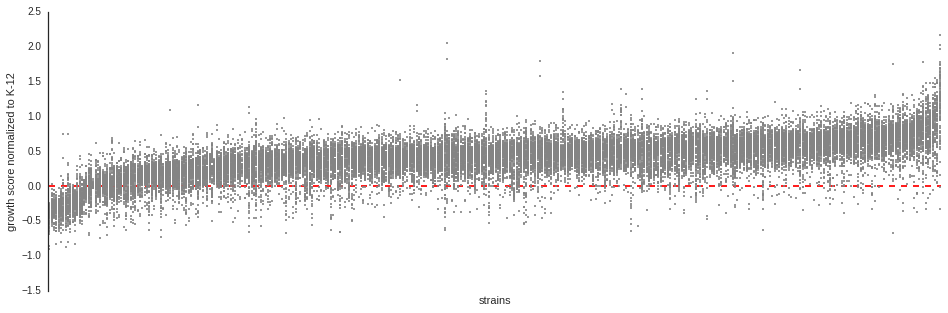

In [21]:
plt.figure(figsize=(16, 5))

# sns.boxplot(data=matrix.T,
#             order=sort.index,
#             color=sns.xkcd_rgb['light grey'])
sns.stripplot(data=matrix.T,
            order=sort.index,
            color=sns.xkcd_rgb['light grey'],
            edgecolor='grey',
            size=1)

plt.hlines(matrix.loc['NT12001'].median(),
           0,
           matrix.shape[0],
           colors='r',
           linestyles='dashed',
           zorder=1)

plt.xticks([])
plt.xlabel('strains')
plt.ylabel('growth score normalized to K-12')

sns.despine(bottom=True)

In [22]:
# Read strains data
a = pd.read_table('../emap.matrix.txt')
a.set_index(['Gene'], inplace=True)
# Load the FDR corrections to identify proper phenotypes
f = pd.read_table('../emap.fdr.txt')
f.set_index('Gene', inplace=True)

# Remove duplicate strains
# and dummy entries
remove = {x for x in a.index
          if '_1' in x
          or '_2' in x
          or '_3' in x
          or '_4' in x
          or 'dummy' in x.lower()}
a = a.drop(remove)
f = f.drop(remove)

# Remove plate 8
remove = {i for i in a.index if '-P8' not in i}
a = a.drop(remove)
f = f.drop(remove)

# Remove those strains that are always nan
remove = {i for i in a.index if list(np.isnan(a.ix[i])).count(True) == len(a.columns)}
a = a.drop(remove)
f = f.drop(remove)
# Same for conditions
remove = {i for i in a.T.index if list(np.isnan(a.T.ix[i])).count(True) == len(a.T.columns)}
a = a.T.drop(remove).T
f = f.T.drop(remove).T

# Fix strain names
a.index = [x.split()[0] for x in a.index]

# Fix strain names
f.index = [x.split()[0] for x in f.index]

# Apply the FDR correction
v = a[f < 0.05]

In [23]:
v = []
for c in set(a.columns).intersection(matrix.columns):
    for strain in set(a.index).intersection(matrix.index):
        if len(a[c][strain].shape) > 0:
            score = a[c][strain][0]
        else:
            score = a[c][strain]
        v.append( (strain, score, matrix[c][strain]) )
v = pd.DataFrame( v )

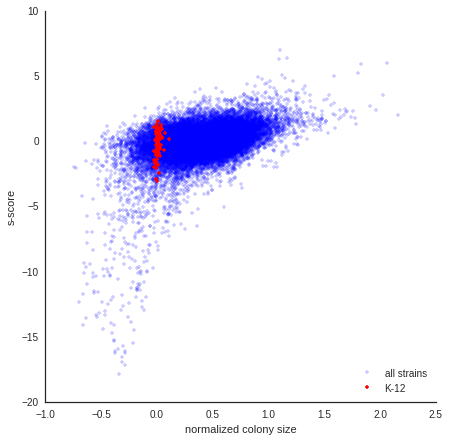

In [24]:
plt.figure(figsize=(7, 7))

plt.plot(v[v[0] != 'NT12001'][2],
         v[v[0] != 'NT12001'][1],
         'b.',
         alpha=0.2,
         label='all strains')
plt.plot(v[v[0] == 'NT12001'][2],
         v[v[0] == 'NT12001'][1],
         'r.',
         alpha=1,
         label='K-12')

plt.legend(loc='lower right')

plt.xlabel('normalized colony size')
plt.ylabel('s-score')

sns.despine()

In [25]:
# FDR approach to the new scoring system?
def mad(data, c=0.6745):
    '''
    Compute the MAD
    
    Equivalent to R's mad function
    '''
    import numpy as np
    
    data = np.ma.masked_array(data.as_matrix(),
               np.isnan(data.as_matrix()))

    return np.ma.median(np.ma.fabs(data - np.ma.median(data))) / c


def median(data):
    import numpy as np

    data = np.ma.masked_array(data.as_matrix(),
                   np.isnan(data.as_matrix()))
    
    return np.ma.median(data)

def get_Zscore(values):
    return (values.as_matrix()-median(values))/mad(values)

def get_sf(values):
    from scipy import stats
    values[np.isnan(values)] = 0
    return stats.norm.sf(abs(values.as_matrix()))*2

def correct_pvals(values):
    from statsmodels.sandbox.stats.multicomp import fdrcorrection0
    values[np.isnan(values)] = 0
    return fdrcorrection0(values.as_matrix(),
                        alpha=0.05,
                        )[1]

In [26]:
matrix = pd.read_table('sizes.matrix.txt')
matrix.set_index('Gene', inplace=True)

In [27]:
mz = matrix.apply(get_Zscore, axis=0)
mp = mz.apply(get_sf, axis=0)
mf = mp.apply(correct_pvals, axis=0)

In [28]:
# Compute the phenotypes rarefaction curve
phen = []
for i in np.concatenate((np.linspace(0.0, .1, num=10),
                         np.linspace(.1, 1, num=10))):
    b = matrix[mf<i]
    b[np.invert(np.isnan(b))] = 1
    b[np.isnan(b)] = 0
    b = b.sum(axis=1)
    phen.append( b[b>0].shape[0] )
sscore = []
for i in np.concatenate((np.linspace(0.0, .1, num=10),
                         np.linspace(.1, 1, num=10))):
    b = a[f<i]
    b[np.invert(np.isnan(b))] = 1
    b[np.isnan(b)] = 0
    b = b.sum(axis=1)
    sscore.append( b[b>0].shape[0] )

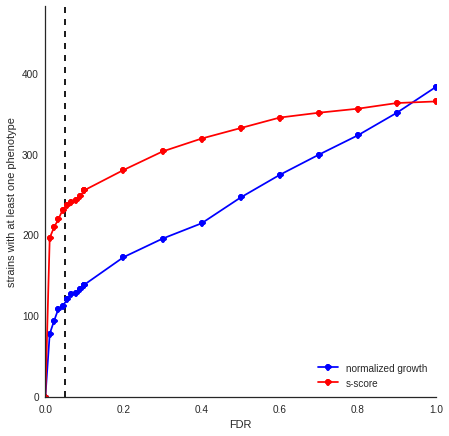

In [29]:
plt.figure(figsize=(7, 7))

plt.plot(np.concatenate((np.linspace(0.0, .1, num=10),
                         np.linspace(.1, 1, num=10))),
             phen,
             'bo-',
        label='normalized growth')
plt.plot(np.concatenate((np.linspace(0.0, .1, num=10),
                         np.linspace(.1, 1, num=10))),
             sscore,
             'ro-',
        label='s-score')

plt.vlines(0.05, 0, max(phen)+100,
           colors='k',
           linestyles='dashed')
plt.ylim(0, len(matrix.index)+100)

plt.xlabel('FDR')
plt.ylabel('strains with at least one phenotype')

plt.legend(loc='lower right')

sns.despine()